In [1]:
import numpy as np
import SimpleITK as sitk
import hydra
from radiomics import featureextractor

from shared_lib.enums import RunMode
from shared_lib.utils.utils_vis import save_plot

In [2]:
with hydra.initialize_config_module(config_module="analyzer.nodule_attr.configs", version_base=None):
    config = hydra.compose(config_name="config_inference", overrides=[])

/opt/conda/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config_inference': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [3]:
# runner
models = dict()
for model_indicator, config_model in config.models.items():
    models[model_indicator] = hydra.utils.instantiate(config_model)
processor = hydra.utils.instantiate(config.processor, models=models)

In [4]:
# run modes
run_modes = [RunMode(m) for m in config.run_modes] if "run_modes" in config else [x for x in RunMode]

In [5]:
# loader
loaders = {
    mode: hydra.utils.instantiate(
        config.loader,
        dataset={"mode": mode},
        drop_last=(mode == RunMode.TRAIN),
        shuffle=(mode == RunMode.TRAIN),
    )
    for mode in run_modes
}

In [6]:
TARGET_INDEX = 2
for i, data in enumerate(loaders[RunMode.TEST]):
    if i == TARGET_INDEX:
        patch_image = data["image"]
        output = processor.predict_given_patch(patch_image)
        break

In [7]:
mask = output["c_segmentation_logistic"]

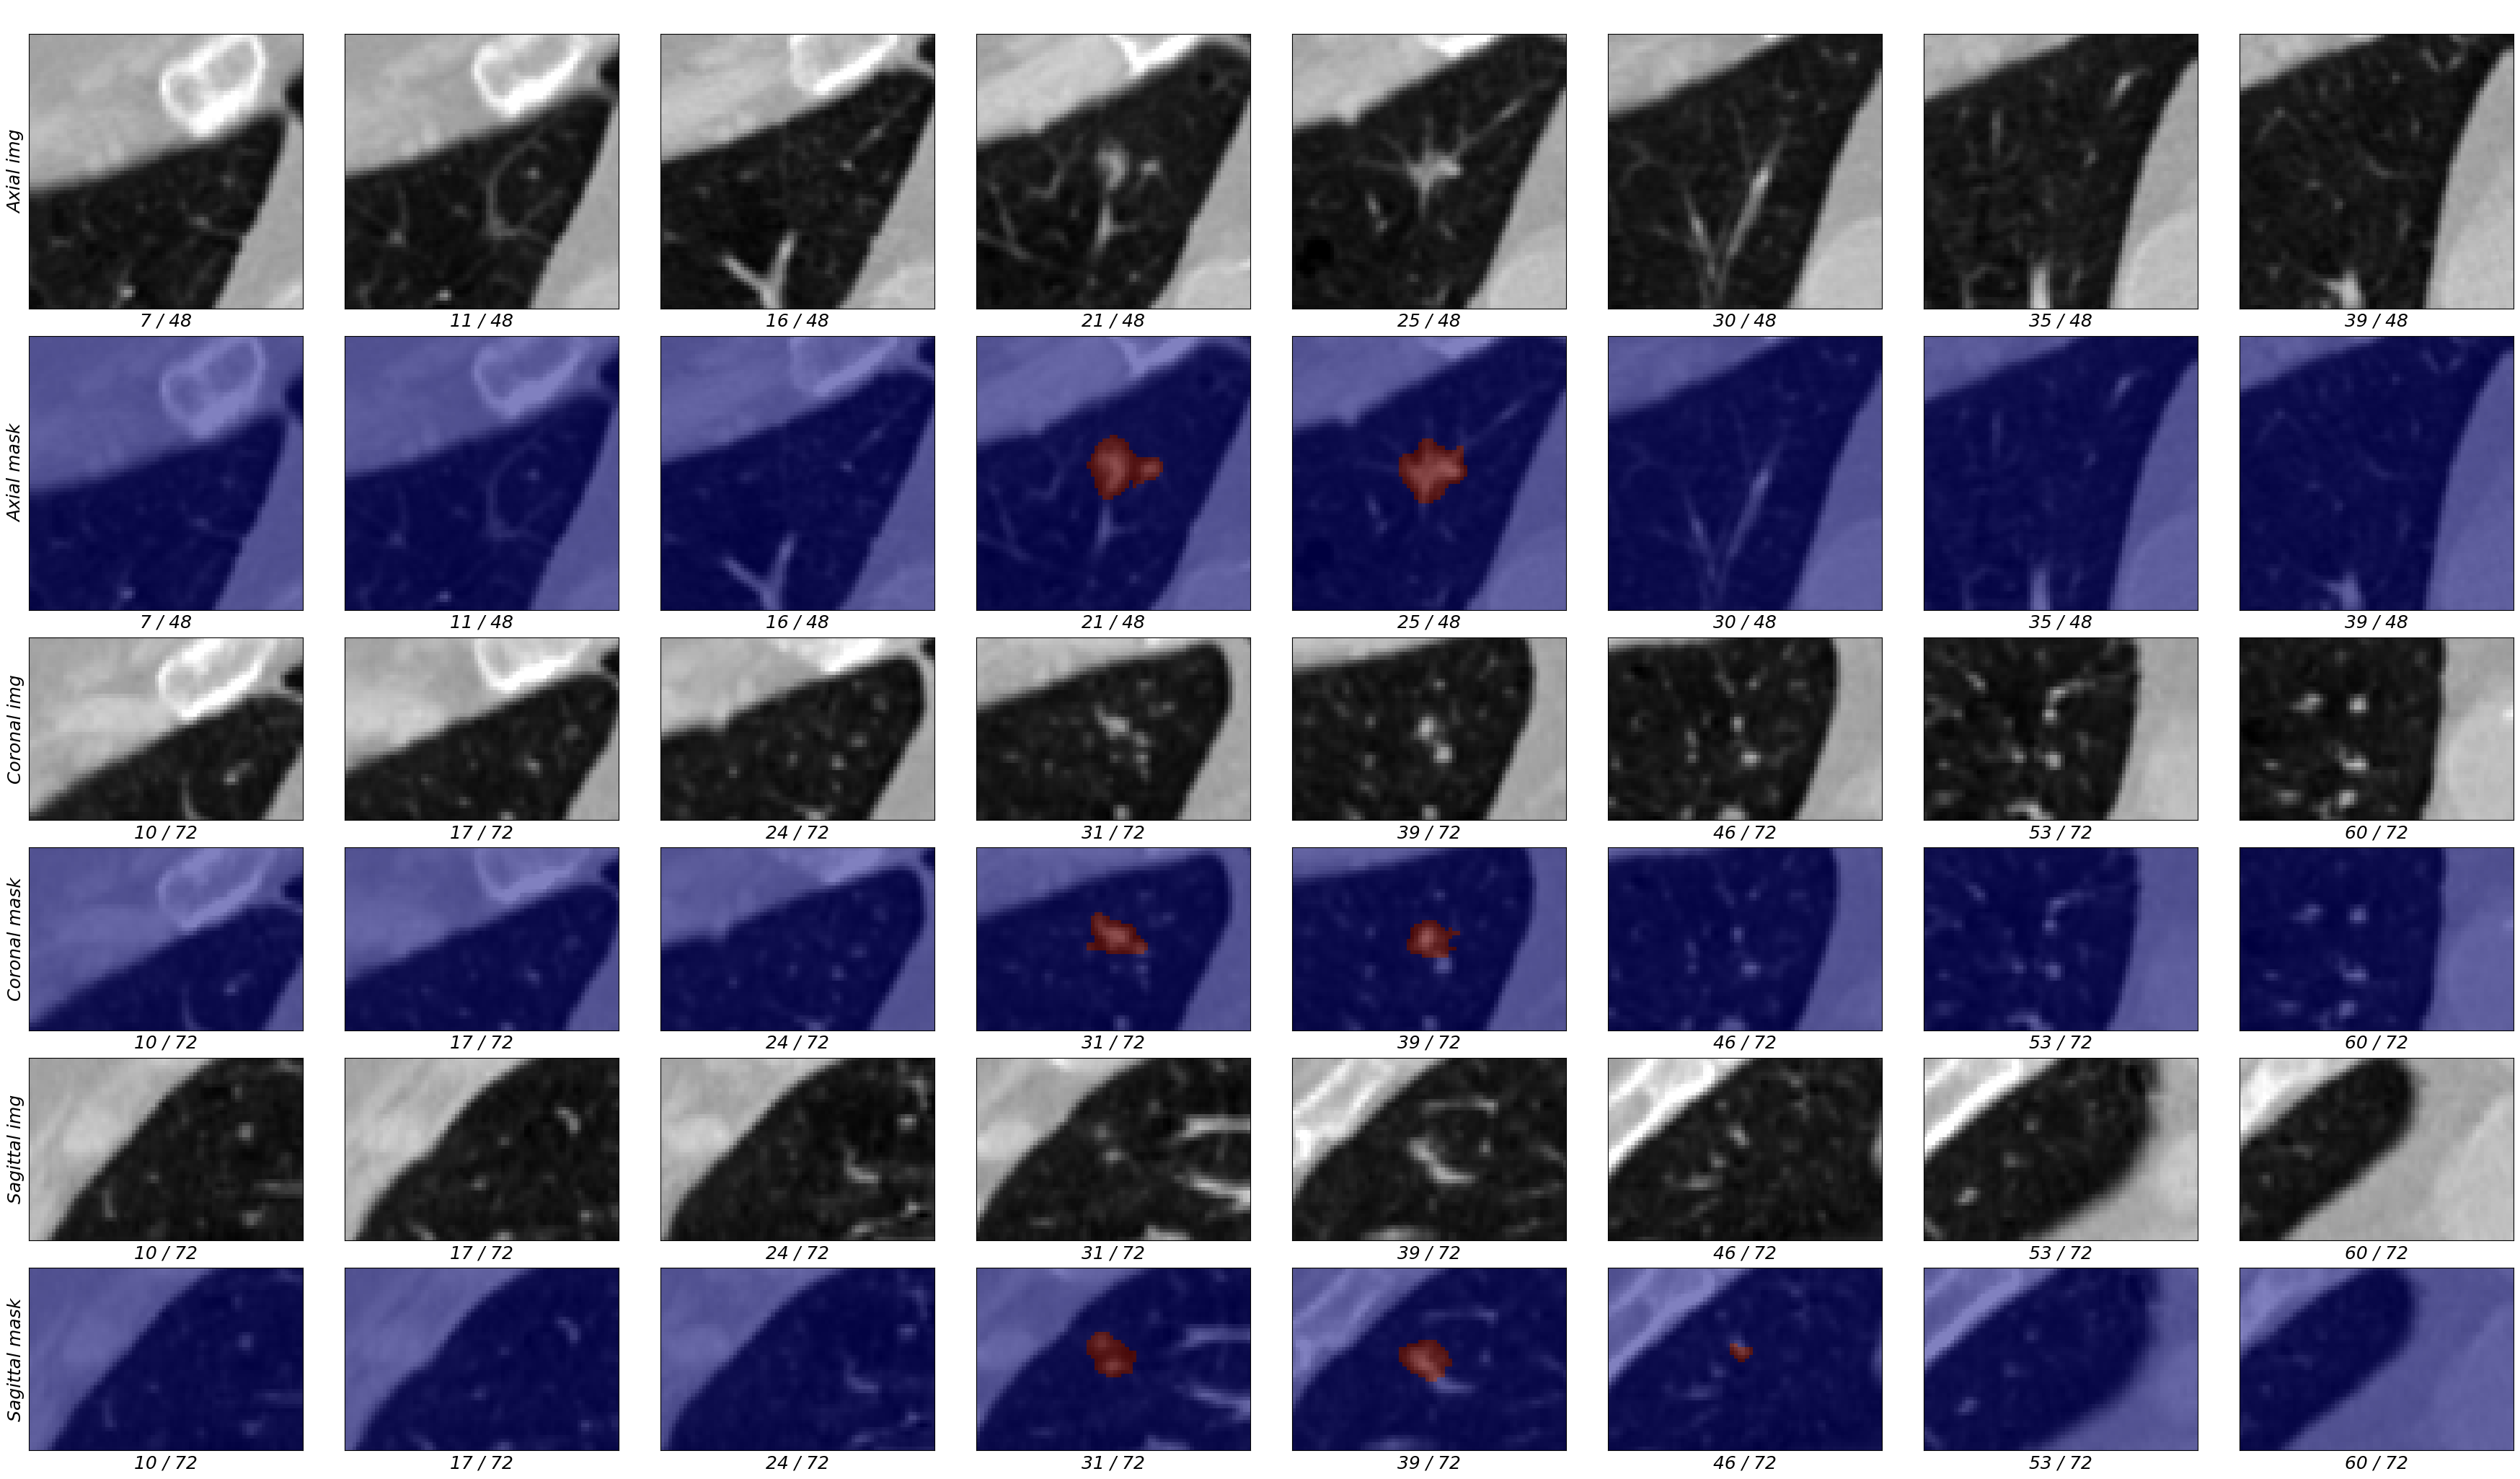

In [8]:
# save visualization result
figure_title = ""
attr = {}

patch = patch_image[0].squeeze().detach().cpu().numpy()

threshold = 0.01
mask = (mask[0].squeeze().detach().cpu().numpy()> threshold).astype(np.uint8)

save_plot(
    input_image=patch,
    mask_image=mask,
    nodule_zyx=None,
    figure_title=figure_title,
    meta=attr,
    use_norm=False,
    save_dir=None,
    dpi=60,
)

In [9]:
image_np = patch
mask_np = mask

# NumPy -> SimpleITK 이미지로 변환
image_sitk = sitk.GetImageFromArray(image_np)
mask_sitk = sitk.GetImageFromArray(mask_np)
spacing = [1.0, 0.67, 0.67]
image_sitk.SetSpacing(spacing[::-1])
mask_sitk.SetSpacing(spacing[::-1])

# PyRadiomics extractor 초기화 (원하면 YAML config 가능)
extractor = featureextractor.RadiomicsFeatureExtractor()

# 이미지와 마스크를 직접 전달
result = extractor.execute(image_sitk, mask_sitk)

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firsto

In [10]:
# 결과 출력
for key, val in result.items():
    print(f"{key}: {val}")

diagnostics_Versions_PyRadiomics: v3.0.1
diagnostics_Versions_Numpy: 1.26.4
diagnostics_Versions_SimpleITK: 2.5.0
diagnostics_Versions_PyWavelet: 1.8.0
diagnostics_Versions_Python: 3.10.17
diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
diagnostics_Image-original_Hash: 50593870aa74dd74c160373a68dc5fe1cc00823a
diagnostics_Image-original_Dimensionality: 3D
diagnostics_Image-original_Spacing: (0.67, 0.67, 1.0)
diagnostics_Image-original_Size: (72, 72, 48)
diagnostics_Image-original_Mean: 0.3329912982086227
diagnostics_Image-original_Minimum: 0.0
diagnostics_Image-original_Maximum: 1.0
diagnostics_Mask-original_H